## ●Notebookの内容

整理後データ(コード3の「データクレンジング」で作成したもの)の読み込み、必要期間のみ抽出、回帰分析、階層クラスタリング、変数選択

# 1. 前準備

## 1.1 パッケージのインポート・乱数固定

In [1]:
import pandas as pd #pandasパッケージをインポート
import numpy as np #numpyパッケージをインポート
import torch #ライブラリ「PyTorch」のtorchパッケージをインポート
import torch.nn as nn #「ニューラルネットワーク」モジュールの別名定義
import torch.nn.functional as F #「ニューラルネットワーク・活性化関数」モジュールの別名定義
import collections
import os
import pickle
import optuna
import torch.optim as optim
from sklearn.linear_model import LinearRegression #回帰分析
import scipy.stats #標準化

#乱数の固定
torch.manual_seed(123)

## 1.2 MPSの使用指定

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
print('MPSの使用は',torch.backends.mps.is_available(),'である(Trueなら使用可能、Falseなら使用不可)。')

MPSの使用は True である(Trueなら使用可能、Falseなら使用不可)。


# 2. 整理後データの読み込み

In [3]:
pickle_in = open("./organized_data3.pickle","rb") #ファイルの読み込み, 配当込み収益率はランク正規化をしていないデータであることに注意
kaiki_data_0 = pickle.load(pickle_in)
pickle_in.close()
display(kaiki_data_0)

,銘柄名,期日,銘柄コード,調整済始値,調整済高値,調整済安値,株価(終値)移動平均25日乖離率,株価(終値)移動平均75日乖離率,株価(終値)移動平均200日乖離率,PER(普通株式数･日経予想･連結優先･含負),...,総還元性向,総資産連単倍率,売上高連単倍率,営業利益連単倍率,経常利益連単倍率,当期利益連単倍率,期末EV/EBITDA,時価総額(発行済株式数ﾍﾞｰｽ),計算用現値（調整済、市場引継）,対TOPIX β値(60ヵ月) 2乗
0,極洋,1994/12,1301.0,3780.0,4190.0,3710.0,2.9185,-1.3674,-7.4138,60.719152,...,34.644268,1.057022,1.049759,1.141331,1.049765,0.946636,35.878976,4.553936e+10,4020.0,1.640167
1,極洋,1995/01,1301.0,4070.0,4130.0,3580.0,-2.8197,-3.9003,-10.0966,58.302469,...,34.801282,1.057022,1.049759,1.141445,1.049182,0.946636,35.878976,4.372685e+10,3860.0,1.621369
2,極洋,1995/02,1301.0,3880.0,4000.0,3460.0,-8.3524,-10.2346,-16.9429,53.167019,...,34.801282,1.057022,1.049759,1.141100,1.047150,0.946636,35.878976,3.987526e+10,3520.0,1.728384
3,極洋,1995/03,1301.0,3520.0,3800.0,3350.0,-3.1339,-10.3753,-17.6057,51.354507,...,34.424683,1.057022,1.049759,1.141879,1.049182,0.946636,35.878976,3.851588e+10,3400.0,1.583596
4,極洋,1995/04,1301.0,3300.0,3700.0,3150.0,1.7775,-3.0125,-11.4933,53.620147,...,34.424683,1.057022,1.049759,1.141879,1.049406,0.946636,35.878976,4.021511e+10,3550.0,1.579018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370820,ベルーナ,2021/08,9997.0,883.0,900.0,773.0,-2.3335,-14.7397,-21.8114,6.358036,...,14.452700,1.123884,1.598314,1.584172,1.541385,1.483134,8.300202,7.993457e+10,822.0,2.385110
370821,ベルーナ,2021/09,9997.0,822.0,892.0,819.0,0.2582,-4.7101,-18.3318,6.605550,...,14.452700,1.123884,1.598314,1.584172,1.541385,1.483134,8.300202,8.304638e+10,854.0,2.379800
370822,ベルーナ,2021/10,9997.0,848.0,851.0,792.0,-3.3851,-6.3116,-22.2559,6.172400,...,14.452700,1.123884,1.598314,1.584172,1.541385,1.483134,8.300202,7.760071e+10,798.0,2.348832
370823,ベルーナ,2021/11,9997.0,793.0,795.0,665.0,-10.6664,-17.3400,-32.4331,5.159130,...,14.452700,1.123884,1.598314,1.584172,1.541385,1.483134,8.300202,6.486175e+10,667.0,2.758423


# 3. 必要期間(学習)データのみ抽出

In [4]:
kaiki_data_1_1 = kaiki_data_0.query('期日.str.contains("199")', engine='python') #1995〜1999のデータを抽出
kaiki_data_1_2 = kaiki_data_0.query('期日.str.contains("200")', engine='python') #2000〜2009のデータを抽出
kaiki_data_1_3 = kaiki_data_0.query('期日.str.contains("2010")', engine='python') #2010のデータを抽出
kaiki_data_1_4 = kaiki_data_0.query('期日.str.contains("2011")', engine='python') #2011のデータを抽出
kaiki_data_1_5 = kaiki_data_0.query('期日.str.contains("2012")', engine='python') #2012のデータを抽出
kaiki_data_1 = pd.concat([kaiki_data_1_1,kaiki_data_1_2,kaiki_data_1_3,kaiki_data_1_4,kaiki_data_1_5], axis=0) #データの結合
display(kaiki_data_1)

,銘柄名,期日,銘柄コード,調整済始値,調整済高値,調整済安値,株価(終値)移動平均25日乖離率,株価(終値)移動平均75日乖離率,株価(終値)移動平均200日乖離率,PER(普通株式数･日経予想･連結優先･含負),...,総還元性向,総資産連単倍率,売上高連単倍率,営業利益連単倍率,経常利益連単倍率,当期利益連単倍率,期末EV/EBITDA,時価総額(発行済株式数ﾍﾞｰｽ),計算用現値（調整済、市場引継）,対TOPIX β値(60ヵ月) 2乗
0,極洋,1994/12,1301.0,3780.0,4190.0,3710.0,2.9185,-1.3674,-7.4138,60.719152,...,34.644268,1.057022,1.049759,1.141331,1.049765,0.946636,35.878976,4.553936e+10,4020.0,1.640167
1,極洋,1995/01,1301.0,4070.0,4130.0,3580.0,-2.8197,-3.9003,-10.0966,58.302469,...,34.801282,1.057022,1.049759,1.141445,1.049182,0.946636,35.878976,4.372685e+10,3860.0,1.621369
2,極洋,1995/02,1301.0,3880.0,4000.0,3460.0,-8.3524,-10.2346,-16.9429,53.167019,...,34.801282,1.057022,1.049759,1.141100,1.047150,0.946636,35.878976,3.987526e+10,3520.0,1.728384
3,極洋,1995/03,1301.0,3520.0,3800.0,3350.0,-3.1339,-10.3753,-17.6057,51.354507,...,34.424683,1.057022,1.049759,1.141879,1.049182,0.946636,35.878976,3.851588e+10,3400.0,1.583596
4,極洋,1995/04,1301.0,3300.0,3700.0,3150.0,1.7775,-3.0125,-11.4933,53.620147,...,34.424683,1.057022,1.049759,1.141879,1.049406,0.946636,35.878976,4.021511e+10,3550.0,1.579018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370712,ベルーナ,2012/08,9997.0,312.0,332.5,303.0,1.0053,4.6045,6.4346,7.959826,...,32.557056,1.140364,1.201852,1.400265,1.087109,0.941460,3.621850,3.661502e+10,323.5,1.643806
370713,ベルーナ,2012/09,9997.0,319.5,329.0,309.5,-1.3895,0.0421,2.5690,7.787587,...,32.557056,1.140364,1.201852,1.400265,1.087109,0.941460,3.621850,3.582274e+10,316.5,1.649247
370714,ベルーナ,2012/10,9997.0,316.5,319.5,284.0,-1.1157,-4.9169,-4.3147,7.283178,...,32.557056,1.140364,1.201852,1.400265,1.087109,0.941460,3.621850,3.350246e+10,296.0,1.630755
370715,ベルーナ,2012/11,9997.0,298.0,317.0,290.5,1.7422,-0.7696,-1.1572,7.529233,...,32.557056,1.140364,1.201852,1.400265,1.087109,0.941460,3.621850,3.463430e+10,306.0,1.499743


In [5]:
kaiki_day_num = kaiki_data_1.期日.nunique(dropna = True) #企業の数
kaiki_com_num = kaiki_data_1.銘柄コード.nunique(dropna = True) #企業の数
print('使用可能な企業数は', kaiki_com_num, '個であり、対象となる期日数は', kaiki_day_num, 'ヶ月である')

使用可能な企業数は 1141 個であり、対象となる期日数は 217 ヶ月である


# 4. データの準備

## 4.1 期日と銘柄コードをキーに並べ替え

In [6]:
kaiki_data_2 = kaiki_data_1.sort_values(by=['期日', '銘柄コード']) #日付と銘柄コードによってソートする
kaiki_data_3 = kaiki_data_2.drop(['銘柄コード'] , axis=1) #銘柄コードを削除
kaiki_data_4 = kaiki_data_3.reset_index().iloc[:,1:] #index番号の振り直し
display(kaiki_data_4)

,銘柄名,期日,調整済始値,調整済高値,調整済安値,株価(終値)移動平均25日乖離率,株価(終値)移動平均75日乖離率,株価(終値)移動平均200日乖離率,PER(普通株式数･日経予想･連結優先･含負),PBR(普通株式数･実績･連結優先),...,総還元性向,総資産連単倍率,売上高連単倍率,営業利益連単倍率,経常利益連単倍率,当期利益連単倍率,期末EV/EBITDA,時価総額(発行済株式数ﾍﾞｰｽ),計算用現値（調整済、市場引継）,対TOPIX β値(60ヵ月) 2乗
0,極洋,1994/12,3780.000000,4190.000000,3710.000000,2.9185,-1.3674,-7.4138,60.719152,5.264058,...,34.644268,1.057022,1.049759,1.141331,1.049765,0.946636,35.878976,4.553936e+10,4020.000000,1.640167
1,日水,1994/12,454.000000,475.000000,444.000000,1.7656,0.1312,-0.8443,277.995744,2.188874,...,34.644268,1.234328,1.193896,1.141331,1.049765,1.018567,12.219780,1.389979e+11,468.000000,1.219898
2,ホウスイ,1994/12,3360.000000,3650.000000,3200.000000,7.0154,2.9238,-4.5953,-120.330000,2.684939,...,34.644268,1.111225,1.128750,1.141331,1.049765,1.018567,-120.932500,1.443960e+10,3600.000000,0.915638
3,カネコ種,1994/12,1145.454534,1218.181806,1109.090898,4.8841,2.3109,0.7095,46.346133,3.064545,...,40.174672,1.111225,1.128750,1.141331,1.049765,1.018567,18.163295,1.390384e+10,1218.181806,1.055552
4,サカタタネ,1994/12,3150.000000,3260.000000,3000.000000,3.1725,0.7387,-2.9803,41.772308,2.396681,...,16.558188,1.035973,1.053762,1.119362,1.093215,1.084722,18.249958,1.629120e+11,3200.000000,0.495517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247592,ジェコス,2012/12,542.000000,594.000000,541.000000,1.8636,10.1954,28.4614,8.729487,0.743542,...,29.158317,1.050061,1.175818,3.663866,3.688488,1.332443,9.577519,2.095070e+10,575.000000,0.208721
247593,ヤマザワ,2012/12,1395.000000,1549.000000,1350.000000,2.8347,5.0448,4.4607,16.377299,0.576431,...,22.632519,1.111274,1.129130,1.150842,1.149033,1.177419,2.148372,1.607832e+10,1467.000000,0.096852
247594,やまや,2012/12,1146.000000,1216.000000,1120.000000,0.1934,3.0683,-8.1773,5.719782,0.660171,...,10.219319,1.182910,1.386683,1.458857,1.448577,1.688731,3.585110,1.258252e+10,1160.000000,0.726483
247595,グローセル,2012/12,257.000000,289.000000,257.000000,7.3345,12.3829,11.5068,11.297705,0.398427,...,41.929825,1.070057,1.091197,2.163677,1.512360,2.807882,7.968705,6.891552e+09,288.000000,1.013183


## 4.2 説明変数と目的変数となるデータフレームを作成

In [7]:
#説明変数となるデータフレームを作成
kaiki_data_5 = kaiki_data_4.drop(['銘柄名','期日', '配当込み収益率(月次)'] , axis=1) #不要な列を削除
#目的変数となるデータフレームを作成
kaiki_data_6 = kaiki_data_4['配当込み収益率(月次)']

# 5. 時点$t$毎かつ1つの指標毎に単回帰分析を実行

## 5.1 単回帰分析の実行

In [8]:
keisu_frame = pd.DataFrame()
#for p in range(kaiki_day_num):
for p in range(kaiki_day_num-1):
    #kaiki_data_7 = kaiki_data_6.iloc[kaiki_com_num*p:kaiki_com_num*(1+p),]
    kaiki_data_7 = kaiki_data_6.iloc[kaiki_com_num*p+1059:kaiki_com_num*(1+p)+1059,]
    dependent = np.array(kaiki_data_7).reshape(-1,1) #目的変数
    #print(kaiki_data_7) #目的変数の表示
    #print(dependent)
    
    for q in range(kaiki_data_5.shape[1]):
        model_lr = LinearRegression()
        kaiki_data_8_1 = kaiki_data_5.iloc[kaiki_com_num*p:kaiki_com_num*(1+p),q]
        #print(kaiki_data_8_1)
        
        #(1)標準化の場合
        #kaiki_data_8_2 = scipy.stats.zscore(kaiki_data_8_1) #標準化の実行
        
        #(2)ランク正規化の場合
        kaiki_data_8_1_1 = kaiki_data_8_1.rank(pct = True) #(0,1)のランク正規化
        #(-1,1)のランク正規化にする
        kaiki_data_8_2 = ((kaiki_data_8_1_1-kaiki_data_8_1_1.min())/(kaiki_data_8_1_1.max()-kaiki_data_8_1_1.min()))*(1-(-1))+(-1)
        
        independent = np.array(kaiki_data_8_2).reshape(-1,1) #説明変数
        #print(independent)
        model_lr.fit(independent, dependent) #回帰分析の実行
        #R_2 = model_lr.score(independent, dependent) #決定係数
        #print(kaiki_data_8_2) #説明変数の表示
        #print('時点%d' %p, 'における', kaiki_data_8_2.name ,'の決定係数は', R_2 ,'である。') #決定係数の表示
        keisu_frame_0 = pd.concat([pd.Series(kaiki_data_8_2.name, name='説明変数'), pd.DataFrame(model_lr.coef_, columns=['回帰係数'])], axis=1)
        keisu_frame = pd.concat([keisu_frame, keisu_frame_0], axis=0)
        print('時点%d' %p, 'における', kaiki_data_8_2.name , 'を説明変数としたモデル関数の回帰係数は  %.10f' %model_lr.coef_) #回帰係数の表示

時点0 における 調整済始値 を説明変数としたモデル関数の回帰係数は  0.0123080966
時点0 における 調整済高値 を説明変数としたモデル関数の回帰係数は  0.0112049851
時点0 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0123219360
時点0 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0077406824
時点0 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0129458107
時点0 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0120019770
時点0 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  -0.0084226299
時点0 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0058934931
時点0 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0175214107
時点0 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0031553762
時点0 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  0.0201104801
時点0 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0147976436
時点0 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  -0.0086548213
時点0 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0101376531
時点0 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0089684816
時点0 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0206381990
時点0 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0152620113
時点0 における HV（1年） を説明変数としたモデル関数の回帰係

時点3 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0046421922
時点3 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  0.0028294183
時点3 における HV（1年） を説明変数としたモデル関数の回帰係数は  0.0056233533
時点3 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0009412611
時点3 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0031469746
時点3 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0048945672
時点3 における 当座比率 を説明変数としたモデル関数の回帰係数は  0.0089093779
時点3 における 固定比率 を説明変数としたモデル関数の回帰係数は  -0.0011459113
時点3 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  0.0001947661
時点3 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  0.0108340559
時点3 における 負債比率 を説明変数としたモデル関数の回帰係数は  -0.0107414453
時点3 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  0.0020594619
時点3 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  -0.0033477923
時点3 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0015582284
時点3 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0055236495
時点3 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  0.0020253786
時点3 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  0.0021626535
時点3 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0007916112
時点3 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰

時点6 における 調整済安値 を説明変数としたモデル関数の回帰係数は  -0.0135462763
時点6 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  0.0004364347
時点6 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0033843058
時点6 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0125458013
時点6 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  0.0046865529
時点6 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0024345812
時点6 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0148565659
時点6 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0036868587
時点6 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0083289807
時点6 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0057830984
時点6 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  0.0102578547
時点6 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0044072783
時点6 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0045374901
時点6 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0155647178
時点6 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  0.0075931234
時点6 における HV（1年） を説明変数としたモデル関数の回帰係数は  0.0057610990
時点6 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0025891978
時点6 における 対TOPIX α値(60ヵ月)

時点9 における 調整済高値 を説明変数としたモデル関数の回帰係数は  -0.0020206792
時点9 における 調整済安値 を説明変数としたモデル関数の回帰係数は  -0.0025372110
時点9 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  0.0007501736
時点9 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0042313949
時点9 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.0012894524
時点9 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  0.0024391822
時点9 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  0.0052878795
時点9 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0004816197
時点9 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0013149027
時点9 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0059087922
時点9 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0041366344
時点9 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  0.0058546629
時点9 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0000267549
時点9 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0066809562
時点9 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0004890500
時点9 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  0.0091651542
時点9 における HV（1年） を説明変数としたモデル関数の回帰係数は  0.0090142383
時点9 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数

時点12 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0070936320
時点12 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.0041842308
時点12 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  0.0045012897
時点12 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0002905086
時点12 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0006900180
時点12 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0020453421
時点12 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0010905612
時点12 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0017522608
時点12 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  0.0036355935
時点12 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0009795241
時点12 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0080622686
時点12 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0020908369
時点12 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0035429220
時点12 における HV（1年） を説明変数としたモデル関数の回帰係数は  -0.0014105491
時点12 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0017676397
時点12 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0023699352
時点12 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0040834001
時点12 における 当座比

時点14 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0035420811
時点14 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0032260423
時点14 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0016749968
時点14 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0030447108
時点14 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0000710059
時点14 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0047165256
時点14 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0138426223
時点14 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0031826190
時点14 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0002418553
時点14 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0037450516
時点14 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0039537691
時点14 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0038042928
時点14 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0014579167
時点14 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.0014977357
時点14 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  -0.0003545537
時点14 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  -0.0060988685
時点14 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  -0.0068679004
時点15 における 調整済始値 を説明変数としたモデル関数の回帰係数は  -0.0004154495
時点15 における 調整済高値 

時点17 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0055008781
時点17 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0004419201
時点17 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0046317957
時点17 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0001885049
時点17 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0002688072
時点17 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0005772360
時点17 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0050199751
時点17 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0008932287
時点17 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  0.0030703586
時点17 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  0.0011767774
時点17 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  0.0056012813
時点17 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  0.0010003038
時点18 における 調整済始値 を説明変数としたモデル関数の回帰係数は  0.0000289597
時点18 における 調整済高値 を説明変数としたモデル関数の回帰係数は  -0.0000512631
時点18 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0000811768
時点18 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0050502652
時点18 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0027977621
時点18 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  -0.00079

時点20 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0097581391
時点20 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0101925224
時点20 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0077626803
時点20 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0026932041
時点20 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  0.0080795157
時点20 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0035284535
時点20 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0033675528
時点20 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  0.0008368139
時点20 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0027007006
時点20 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0019623274
時点20 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0009303570
時点20 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0046065070
時点20 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0018794995
時点20 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0012434667
時点20 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0030819526
時点20 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0022661882
時点20 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0020360248
時点20 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0024509685
時点20 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.00178

時点23 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0036183924
時点23 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0014515149
時点23 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0037740649
時点23 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0051962429
時点23 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  -0.0038853400
時点23 における 税率 を説明変数としたモデル関数の回帰係数は  0.0026252132
時点23 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0050634056
時点23 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  0.0059592124
時点23 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0020665878
時点23 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0028227256
時点23 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0015974648
時点23 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0073171415
時点23 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  0.0031388709
時点23 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0022234021
時点23 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0057657396
時点23 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  0.0009389836
時点23 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0057472647
時点23 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0042802506
時点23 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.003914703

時点27 における 調整済始値 を説明変数としたモデル関数の回帰係数は  -0.0073495036
時点27 における 調整済高値 を説明変数としたモデル関数の回帰係数は  -0.0073877187
時点27 における 調整済安値 を説明変数としたモデル関数の回帰係数は  -0.0070610154
時点27 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  0.0046326078
時点27 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0118415626
時点27 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.0103246328
時点27 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  -0.0020834359
時点27 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  0.0017987154
時点27 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0071905250
時点27 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0103187873
時点27 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0007899064
時点27 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0106024657
時点27 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  -0.0042388849
時点27 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0042501410
時点27 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0128174820
時点27 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0082216060
時点27 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0061770259
時点27 における HV（1年） を説明変

時点29 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0006472035
時点29 における 税率 を説明変数としたモデル関数の回帰係数は  0.0074832365
時点29 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0038219852
時点29 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0019801685
時点29 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0084874836
時点29 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0070781905
時点29 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0044636993
時点29 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0005418735
時点29 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0089652738
時点29 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0008634911
時点29 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0017026314
時点29 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0027564976
時点29 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0067099656
時点29 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0059500818
時点29 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0062104642
時点29 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0080274332
時点29 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0050626323
時点29 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0037031876
時点29 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.00056000

時点32 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0021851093
時点32 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  -0.0069520583
時点32 における 税率 を説明変数としたモデル関数の回帰係数は  0.0174499054
時点32 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0138057839
時点32 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  0.0240827323
時点32 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0092855098
時点32 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0075415935
時点32 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0164799689
時点32 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0161705155
時点32 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  0.0145580285
時点32 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0123160222
時点32 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0075947973
時点32 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0006276444
時点32 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0010100005
時点32 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0002093756
時点32 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0083386128
時点32 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0029025245
時点32 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0119572198
時点32 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0023826483

時点35 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0179805594
時点35 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0175974153
時点35 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  0.0108986673
時点35 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0042941872
時点35 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0050215515
時点35 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0037894265
時点35 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0018398973
時点35 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0007239900
時点35 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0047619051
時点35 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0043787794
時点35 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0035776769
時点35 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0087628786
時点35 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0074495662
時点35 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0053134923
時点35 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0006220748
時点35 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0046734368
時点35 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.0035563216
時点35 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  0.0030003259
時点35 における 計算用現値（調整済、市場引継） を説明変数としたモデル

時点38 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0023666787
時点38 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  0.0012296811
時点38 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0026980167
時点38 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0027057108
時点38 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0030631357
時点38 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0029938472
時点38 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  0.0021314729
時点38 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0017092661
時点38 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0039365576
時点38 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0061336380
時点38 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0062522849
時点38 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0059368725
時点38 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0061562150
時点38 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0014073605
時点38 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  0.0049164028
時点38 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0005145554
時点38 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0045243478
時点38 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0044464372
時点38 における 税率 を説明変数と

時点41 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  0.0030368159
時点41 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  0.0023806997
時点41 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  0.0049757227
時点41 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  0.0055514071
時点41 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  0.0025369132
時点41 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0051048327
時点41 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0083880279
時点41 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  -0.0030967107
時点41 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  0.0023690038
時点41 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  0.0047738158
時点41 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0013057219
時点41 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0013509678
時点41 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0039411476
時点41 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0035401346
時点41 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0018647082
時点41 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0031343809
時点41 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0034594159
時点41 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0013017742
時点41 における 自己資本利益率(ROE) を説明

時点44 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0038944275
時点44 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0025694832
時点44 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0035415768
時点44 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0035077551
時点44 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0002290042
時点44 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0017872633
時点44 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0072654531
時点44 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0056340448
時点44 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  0.0050671776
時点44 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  0.0024457077
時点44 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  0.0008533561
時点44 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0007214148
時点44 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0024004553
時点44 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  -0.0024064255
時点44 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0009449197
時点44 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0013236390
時点44 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0046123812
時点44 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0015365319
時点44 における 企業利潤率 を

時点47 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  -0.0022378285
時点47 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0032575038
時点47 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0109694777
時点47 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0116536912
時点47 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  0.0020944916
時点47 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0041527225
時点47 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  0.0007296117
時点47 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0295473717
時点47 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0271830096
時点47 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0104387658
時点47 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0066079077
時点47 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0090511297
時点47 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0109207314
時点47 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0068261009
時点47 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0130779311
時点47 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0276185062
時点47 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0270088916
時点47 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0229827058
時点47 における 売上高純金利負担率 

時点50 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  0.0123016552
時点50 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0046855903
時点50 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0022027782
時点50 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  0.0016084413
時点50 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0048649100
時点50 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0048623369
時点50 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0036889949
時点50 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  -0.0120602513
時点50 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  0.0167216927
時点50 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  0.0030485838
時点50 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0030582193
時点50 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0040485465
時点50 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0073544919
時点50 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0075985877
時点50 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  -0.0070953851
時点50 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0093766658
時点50 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0031964585
時点50 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0072178943
時点50 における 自己資本利益

時点53 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0240998729
時点53 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  0.0166802638
時点53 における HV（1年） を説明変数としたモデル関数の回帰係数は  0.0071655567
時点53 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0182209964
時点53 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0066504047
時点53 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0098483975
時点53 における 当座比率 を説明変数としたモデル関数の回帰係数は  0.0100371191
時点53 における 固定比率 を説明変数としたモデル関数の回帰係数は  -0.0093174103
時点53 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  -0.0154834455
時点53 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  -0.0021811871
時点53 における 負債比率 を説明変数としたモデル関数の回帰係数は  0.0027677689
時点53 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  0.0068900550
時点53 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  0.0012784683
時点53 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0069005924
時点53 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0027702216
時点53 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0112126357
時点53 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  0.0029168573
時点53 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0057617401
時点53 における 財務ﾚﾊﾞﾚｯｼ

時点56 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  0.0174110937
時点56 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  0.0146834364
時点56 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  -0.0123544296
時点56 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0084667129
時点56 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0134520538
時点56 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0174267371
時点56 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  0.0013592224
時点56 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0090990038
時点56 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  0.0004591232
時点56 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0105154761
時点56 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0129935486
時点56 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0034594388
時点56 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0023303042
時点56 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0025846996
時点56 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0052150727
時点56 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0066250628
時点56 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0067658850
時点56 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0129229673
時点56 における 売上高販管費率 を説明変

時点59 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0033088141
時点59 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0021392907
時点59 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0048070202
時点59 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0029486704
時点59 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  0.0070883468
時点59 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  0.0048203071
時点59 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0130716533
時点59 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0083674192
時点59 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0045932843
時点59 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0012802399
時点59 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  -0.0003342357
時点59 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0046766143
時点59 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0041771708
時点59 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0036328467
時点59 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  0.0049486153
時点59 における HV（1年） を説明変数としたモデル関数の回帰係数は  0.0094430716
時点59 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0041261126
時点59 における 

時点62 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  -0.0001829672
時点62 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0054665206
時点62 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0021534210
時点62 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0076849546
時点62 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0074343609
時点62 における HV（1年） を説明変数としたモデル関数の回帰係数は  -0.0116082385
時点62 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0091932905
時点62 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0044273685
時点62 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0076299261
時点62 における 当座比率 を説明変数としたモデル関数の回帰係数は  0.0077588541
時点62 における 固定比率 を説明変数としたモデル関数の回帰係数は  0.0030960119
時点62 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  -0.0022771240
時点62 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  0.0121994798
時点62 における 負債比率 を説明変数としたモデル関数の回帰係数は  -0.0111703231
時点62 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  0.0016382668
時点62 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  -0.0016025402
時点62 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0098317832
時点62 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0080858102
時点62 における 有形固定資産比率 

時点64 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0028162768
時点64 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0130147236
時点64 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0032597632
時点64 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0048577842
時点64 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0124833372
時点64 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0138965943
時点64 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0141499387
時点64 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0016076118
時点64 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  0.0107854206
時点64 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  0.0059590608
時点64 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  0.0027613030
時点64 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  -0.0052516744
時点65 における 調整済始値 を説明変数としたモデル関数の回帰係数は  -0.0057906460
時点65 における 調整済高値 を説明変数としたモデル関数の回帰係数は  -0.0053536468
時点65 における 調整済安値 を説明変数としたモデル関数の回帰係数は  -0.0061985126
時点65 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0100707678
時点65 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0013297414
時点65 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.016868824

時点67 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0004858045
時点67 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0012261935
時点67 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0012387324
時点67 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0091945952
時点67 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0047420360
時点67 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0011479516
時点67 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0056142799
時点67 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0020070964
時点67 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0023689408
時点67 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0055870424
時点67 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0055359585
時点67 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0057850951
時点67 における 総還元性向 を説明変数としたモデル関数の回帰係数は  -0.0036917807
時点67 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0090507202
時点67 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0099833181
時点67 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0120571698
時点67 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0129872515
時点67 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0066088057
時点67 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  0.0044

時点70 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0110695695
時点70 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0005934179
時点70 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0006319135
時点70 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  -0.0049995573
時点70 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0054264398
時点70 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0063399051
時点70 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0016777040
時点70 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0093808936
時点70 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0080204653
時点70 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0007109107
時点70 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0022554136
時点70 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  0.0031664466
時点70 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0035859053
時点70 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0082292154
時点70 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0018798529
時点70 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0048455405
時点70 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0057934597
時点70 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0043752608
時点70 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は 

時点73 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0007040329
時点73 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  -0.0077785137
時点73 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  0.0101967834
時点73 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0036639101
時点73 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0077312939
時点73 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0079058008
時点73 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0050708920
時点73 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0080195036
時点73 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0038972694
時点73 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0053531908
時点73 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0083820580
時点73 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  0.0026474025
時点73 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  0.0073076814
時点73 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0059515355
時点73 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0033507352
時点73 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0092242456
時点73 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0014767410
時点73 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  0.0001275323
時点73 における 固定資産回転率 を説明変数としたモデル関

時点76 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  -0.0038831106
時点76 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0035992393
時点76 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  -0.0034680746
時点76 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0070132069
時点76 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0099227352
時点76 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0031611754
時点76 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0023647379
時点76 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0012956887
時点76 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0036822802
時点76 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0059755544
時点76 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0088499104
時点76 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0097643021
時点76 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0079355563
時点76 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0165128512
時点76 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  0.0008215695
時点76 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0004194711
時点76 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0059656960
時点76 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0075044765
時点76 における 総資産事業利益率(ROA) を説明

時点79 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  0.0056179416
時点79 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  0.0089646858
時点79 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  0.0036265366
時点79 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0071938132
時点79 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  0.0140452820
時点79 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  0.0088903003
時点79 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  0.0086878948
時点79 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  0.0039437474
時点79 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  0.0088155536
時点79 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0050367581
時点79 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0101541848
時点79 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  -0.0140957526
時点79 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  0.0178480493
時点79 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  0.0057332715
時点79 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  0.0019390974
時点79 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  0.0006881118
時点79 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0022100913
時点79 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0012830509
時点79 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係

時点82 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  -0.0087252432
時点82 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  -0.0111475476
時点82 における 負債比率 を説明変数としたモデル関数の回帰係数は  0.0110873901
時点82 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  -0.0024443006
時点82 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  0.0033917381
時点82 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  0.0030402530
時点82 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  0.0030266382
時点82 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0040211805
時点82 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  -0.0022762164
時点82 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0001752411
時点82 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0111441440
時点82 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0122428346
時点82 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  -0.0084187674
時点82 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0108396101
時点82 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  0.0048753869
時点82 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0072331873
時点82 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0251027049
時点82 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0097468657
時点82 における 売上高

時点85 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0088901042
時点85 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0119656691
時点85 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  -0.0007298203
時点85 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0033747824
時点85 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0016104110
時点85 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0056558822
時点85 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0087217341
時点85 における HV（1年） を説明変数としたモデル関数の回帰係数は  -0.0091794476
時点85 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0000291693
時点85 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0154839496
時点85 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0086401087
時点85 における 当座比率 を説明変数としたモデル関数の回帰係数は  0.0093817644
時点85 における 固定比率 を説明変数としたモデル関数の回帰係数は  -0.0049031239
時点85 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  -0.0037156264
時点85 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  0.0081143234
時点85 における 負債比率 を説明変数としたモデル関数の回帰係数は  -0.0086499691
時点85 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  0.0158898851
時点85 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  -0.0079289908
時点85 における 長期借入金

時点88 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0013416315
時点88 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0030039917
時点88 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0041716049
時点88 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  0.0033358717
時点88 における HV（1年） を説明変数としたモデル関数の回帰係数は  -0.0041355649
時点88 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0006658044
時点88 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0031920132
時点88 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0031974114
時点88 における 当座比率 を説明変数としたモデル関数の回帰係数は  -0.0004997535
時点88 における 固定比率 を説明変数としたモデル関数の回帰係数は  -0.0007581314
時点88 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  0.0021158734
時点88 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  0.0050047305
時点88 における 負債比率 を説明変数としたモデル関数の回帰係数は  -0.0047909106
時点88 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  0.0050178618
時点88 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  -0.0048186440
時点88 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0028638538
時点88 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0035893464
時点88 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0014473254
時点88 における 手元流動性比率(月) を

時点91 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0020807650
時点91 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0076692581
時点91 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  0.0003690819
時点91 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0062298331
時点91 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0047353230
時点91 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0048368717
時点91 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0012694060
時点91 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0023768485
時点91 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  -0.0111045599
時点91 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0009929854
時点91 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0042073134
時点91 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0082479162
時点91 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0026194489
時点91 における HV（1年） を説明変数としたモデル関数の回帰係数は  -0.0024506319
時点91 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0062783814
時点91 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0099831529
時点91 における 流動比率 を説明変数としたモデル関数の回帰係数は  -0.0073618320
時点91

時点93 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0050819480
時点93 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0107644705
時点93 における 総還元性向 を説明変数としたモデル関数の回帰係数は  -0.0009911191
時点93 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0023186175
時点93 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0011931799
時点93 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0075879097
時点93 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0075511748
時点93 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0072693407
時点93 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  0.0025171723
時点93 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  0.0001957947
時点93 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  0.0086947344
時点93 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  0.0034711372
時点94 における 調整済始値 を説明変数としたモデル関数の回帰係数は  -0.0018729495
時点94 における 調整済高値 を説明変数としたモデル関数の回帰係数は  -0.0016110464
時点94 における 調整済安値 を説明変数としたモデル関数の回帰係数は  -0.0028897685
時点94 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0042203821
時点94 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0036216245
時点94 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.000

時点96 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0094059691
時点96 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0085420954
時点96 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0020876184
時点96 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0011564993
時点96 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0016199235
時点96 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0088323836
時点96 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0104355658
時点96 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0062087838
時点96 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0026069040
時点96 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0096500653
時点96 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  0.0034577478
時点96 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  -0.0043485424
時点96 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  -0.0096168142
時点96 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  0.0121000940
時点97 における 調整済始値 を説明変数としたモデル関数の回帰係数は  0.0062915926
時点97 における 調整済高値 を説明変数としたモデル関数の回帰係数は  0.0060590692
時点97 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0064387535
時点97 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0012245397
時点97 における 株価(終値

時点99 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0021313153
時点99 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  -0.0017352356
時点99 における 税率 を説明変数としたモデル関数の回帰係数は  0.0034151712
時点99 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0036929348
時点99 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  0.0125734448
時点99 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0003782515
時点99 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0036693125
時点99 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0078848708
時点99 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0146920946
時点99 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  0.0144761373
時点99 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  0.0002207865
時点99 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0158831898
時点99 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  0.0108552011
時点99 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0019804052
時点99 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0036910440
時点99 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0013936141
時点99 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0088554284
時点99 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0067226956
時点99 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0009897974
時点9

時点102 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  0.0017173903
時点102 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0007908768
時点102 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0023562217
時点102 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0069895316
時点102 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0016499997
時点102 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0074583072
時点102 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0078057179
時点102 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0104535974
時点102 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0069851635
時点102 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0015930896
時点102 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0098484112
時点102 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0026388807
時点102 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0059931028
時点102 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0030890078
時点102 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0007772174
時点102 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0043322162
時点102 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0037210336
時点102 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0008423229
時点102 における 総還元性向 を説明変数としたモデル

時点105 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  -0.0054384909
時点105 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0072603110
時点105 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0068521696
時点105 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0016524483
時点105 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0002467415
時点105 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0075615173
時点105 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  -0.0041805954
時点105 における 税率 を説明変数としたモデル関数の回帰係数は  0.0045210245
時点105 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0084593436
時点105 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0102969365
時点105 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0032001353
時点105 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0039976513
時点105 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0170653076
時点105 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0074477106
時点105 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0108884779
時点105 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0004343460
時点105 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0056256051
時点105 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  0.0184444523
時点105 における 営業利益伸

時点108 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  0.0017907296
時点108 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  0.0051553009
時点108 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  0.0054970039
時点108 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  0.0019646513
時点108 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0045544131
時点108 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0010350714
時点108 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  -0.0151781439
時点108 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  0.0133321582
時点108 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0035194523
時点108 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0129369701
時点108 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0112378864
時点108 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0059322973
時点108 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0084199792
時点108 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0058446111
時点108 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0075118453
時点108 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0081398193
時点108 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  0.0001049819
時点108 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  0.0040597497
時点108

時点111 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0118361436
時点111 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0119930392
時点111 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0083350601
時点111 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0110906956
時点111 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0111475042
時点111 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0178414339
時点111 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0267177100
時点111 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0288804022
時点111 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0208901898
時点111 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0017284676
時点111 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0043522547
時点111 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0097125839
時点111 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0102039999
時点111 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  -0.0112474640
時点111 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0106920622
時点111 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0098442628
時点111 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0023102339
時点111 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.004

時点114 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0208485615
時点114 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0190286953
時点114 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0160625605
時点114 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0192875268
時点114 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0061293681
時点114 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0094234791
時点114 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0145329478
時点114 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0128306597
時点114 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  -0.0146854990
時点114 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0135721663
時点114 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0140489403
時点114 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0075444187
時点114 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0129504513
時点114 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0124057221
時点114 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  -0.0108009685
時点114 における 税率 を説明変数としたモデル関数の回帰係数は  0.0027839019
時点114 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0049237614
時点114 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0074021860
時点1

時点117 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0033772673
時点117 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0034727197
時点117 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0026499917
時点117 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0007201596
時点117 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0012007824
時点117 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  -0.0071495045
時点117 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  0.0054131510
時点117 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  0.0027139997
時点117 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  0.0015970612
時点117 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  0.0005635557
時点117 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0016847758
時点117 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0025332841
時点117 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0000676081
時点117 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0003246844
時点117 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0011478744
時点117 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0002091240
時点117 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0035224137
時点117 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0013823768
時点1

時点120 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0020729407
時点120 における HV（1年） を説明変数としたモデル関数の回帰係数は  -0.0008178199
時点120 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0018218258
時点120 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0015847077
時点120 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0047151831
時点120 における 当座比率 を説明変数としたモデル関数の回帰係数は  0.0046886673
時点120 における 固定比率 を説明変数としたモデル関数の回帰係数は  -0.0036775567
時点120 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  -0.0013696040
時点120 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  0.0045007636
時点120 における 負債比率 を説明変数としたモデル関数の回帰係数は  -0.0045662178
時点120 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  0.0050899569
時点120 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  -0.0063621593
時点120 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0077705222
時点120 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0051246942
時点120 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0032640636
時点120 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  0.0027157997
時点120 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0016488325
時点120 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  -0.00440

時点123 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0002521254
時点123 における HV（1年） を説明変数としたモデル関数の回帰係数は  0.0028370693
時点123 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0028245248
時点123 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0068219171
時点123 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0004755743
時点123 における 当座比率 を説明変数としたモデル関数の回帰係数は  -0.0020949117
時点123 における 固定比率 を説明変数としたモデル関数の回帰係数は  -0.0034360825
時点123 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  -0.0037907517
時点123 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  -0.0049187788
時点123 における 負債比率 を説明変数としたモデル関数の回帰係数は  0.0049249679
時点123 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  0.0013499370
時点123 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  -0.0014825556
時点123 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  0.0004133735
時点123 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0008691297
時点123 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0059346454
時点123 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  -0.0024500322
時点123 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0010323279
時点123 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.00489987

時点126 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0027504744
時点126 における 流動比率 を説明変数としたモデル関数の回帰係数は  0.0004451336
時点126 における 当座比率 を説明変数としたモデル関数の回帰係数は  -0.0006232655
時点126 における 固定比率 を説明変数としたモデル関数の回帰係数は  -0.0010194809
時点126 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  -0.0022963436
時点126 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  -0.0005429319
時点126 における 負債比率 を説明変数としたモデル関数の回帰係数は  0.0005443761
時点126 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  -0.0029234975
時点126 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  0.0007374751
時点126 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0000550114
時点126 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  0.0018116793
時点126 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0026474046
時点126 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  0.0008593497
時点126 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0025634996
時点126 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0004870487
時点126 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0018116773
時点126 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  0.0026581729
時点126 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0009192360


時点129 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0008482094
時点129 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0022471063
時点129 における 流動比率 を説明変数としたモデル関数の回帰係数は  -0.0123645146
時点129 における 当座比率 を説明変数としたモデル関数の回帰係数は  -0.0082780025
時点129 における 固定比率 を説明変数としたモデル関数の回帰係数は  0.0104397991
時点129 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  0.0101168447
時点129 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  -0.0060991074
時点129 における 負債比率 を説明変数としたモデル関数の回帰係数は  0.0059284488
時点129 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  -0.0039128345
時点129 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  0.0058783669
時点129 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  0.0043099920
時点129 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  0.0039466224
時点129 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  0.0117243671
時点129 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  -0.0067009911
時点129 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0037303324
時点129 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0057027240
時点129 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0103934695
時点129 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  -0.0004

時点131 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0000687761
時点131 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0000933946
時点131 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0009390464
時点131 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0097459811
時点131 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.0102146710
時点131 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  -0.0006667201
時点131 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  -0.0038850976
時点131 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  -0.0064091266
時点132 における 調整済始値 を説明変数としたモデル関数の回帰係数は  0.0018109101
時点132 における 調整済高値 を説明変数としたモデル関数の回帰係数は  0.0010067475
時点132 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0015677232
時点132 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0047354408
時点132 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0038602073
時点132 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.0043559943
時点132 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  0.0093826800
時点132 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  0.0026748215
時点132 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0071

時点134 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.0053746746
時点134 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  0.0069285423
時点134 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  0.0082140882
時点134 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  0.0085395723
時点135 における 調整済始値 を説明変数としたモデル関数の回帰係数は  0.0032440279
時点135 における 調整済高値 を説明変数としたモデル関数の回帰係数は  0.0035325234
時点135 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0030590898
時点135 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  0.0079398758
時点135 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0017263308
時点135 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0009761363
時点135 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  -0.0046901536
時点135 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  0.0037420596
時点135 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0028995248
時点135 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0035603484
時点135 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0038490655
時点135 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0047425160
時点135 における 出来高回転率(250日) を説明変数としたモデル関

時点137 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0038638902
時点137 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0006008306
時点137 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0050307567
時点137 における 総還元性向 を説明変数としたモデル関数の回帰係数は  -0.0027971840
時点137 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0029175716
時点137 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0048029455
時点137 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0052354558
時点137 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0028799560
時点137 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0034253989
時点137 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.0015248674
時点137 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  -0.0003833370
時点137 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  -0.0006886705
時点137 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  0.0005253906
時点138 における 調整済始値 を説明変数としたモデル関数の回帰係数は  0.0012153550
時点138 における 調整済高値 を説明変数としたモデル関数の回帰係数は  0.0011448554
時点138 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0006982042
時点138 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  -0.0006688038
時点138 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  -0

時点140 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0049233039
時点140 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0068091362
時点140 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0010057486
時点140 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0044208804
時点140 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0072434402
時点140 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  0.0024982885
時点140 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0068075002
時点140 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0021201858
時点140 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0002876744
時点140 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0001255195
時点140 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0040315877
時点140 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0086175428
時点140 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0005145421
時点140 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0095974327
時点140 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0087004269
時点140 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0107616409
時点140 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0100563938
時点140 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0093959219
時点140 における 期末EV/EBITDA を説明変

時点143 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0055291547
時点143 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0121934917
時点143 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0008057121
時点143 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0007730449
時点143 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0111694866
時点143 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0129084042
時点143 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0042080406
時点143 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  0.0040916650
時点143 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0034272103
時点143 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  0.0040230453
時点143 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0074918256
時点143 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0075148840
時点143 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0048947372
時点143 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0104795538
時点143 における 総還元性向 を説明変数としたモデル関数の回帰係数は  -0.0097974209
時点143 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  0.0013886168
時点143 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  0.0036558334
時点143 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0078620285
時点143 における 経常利益連単倍率 を説明変数としたモデル関数の回

時点146 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  -0.0020423350
時点146 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0017246215
時点146 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0028968196
時点146 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0030347302
時点146 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0021156080
時点146 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0012930796
時点146 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0005419930
時点146 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0023463662
時点146 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0037710006
時点146 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0024099986
時点146 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0010272535
時点146 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0009930991
時点146 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0001473876
時点146 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0002972417
時点146 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0040511784
時点146 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0026471055
時点146 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0016721348
時点146 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0019887213
時点146 における 営業利益

時点149 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0084008695
時点149 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0100411921
時点149 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0098967842
時点149 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0082354129
時点149 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  0.0085929190
時点149 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  0.0083270245
時点149 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0101990533
時点149 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0122499991
時点149 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0009955004
時点149 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0036219087
時点149 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0069679368
時点149 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0092604280
時点149 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0089430657
時点149 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0118867038
時点149 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0029214830
時点149 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0028277721
時点149 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  0.0081018317
時点149 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0067376357
時点149 における 売上高伸び率 を説明変数と

時点152 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  0.0000773962
時点152 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0056504949
時点152 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0087151885
時点152 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0143296922
時点152 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0148511139
時点152 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0132106959
時点152 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0134131712
時点152 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0130734501
時点152 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  0.0109233020
時点152 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  0.0085083509
時点152 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0119368663
時点152 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0134649547
時点152 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0012676545
時点152 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0047112032
時点152 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0063533291
時点152 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0048428478
時点152 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0078485656
時点152 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0051685477
時点152 における 売上債

時点155 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0023205288
時点155 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0041898491
時点155 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0047348527
時点155 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0020649301
時点155 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  0.0029323215
時点155 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  0.0020104824
時点155 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0041333438
時点155 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0058456147
時点155 における 税率 を説明変数としたモデル関数の回帰係数は  0.0065050811
時点155 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0059301363
時点155 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0068159915
時点155 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0119816998
時点155 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0097135677
時点155 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0060240146
時点155 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0088761234
時点155 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0049429929
時点155 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  0.0051201514
時点155 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0046687301
時点155 における 売上高伸び率 を説明変数とし

時点158 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  0.0071783524
時点158 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  0.0045023158
時点158 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  0.0091496012
時点158 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  0.0005286788
時点158 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  0.0012714628
時点158 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0018774711
時点158 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0092131101
時点158 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0045891665
時点158 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  -0.0033951391
時点158 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0000033655
時点158 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  -0.0018849099
時点158 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0137894488
時点158 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0087828642
時点158 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0001242315
時点158 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  0.0003024983
時点158 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0013534219
時点158 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0023625082
時点158 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.001224

時点161 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  -0.0006785552
時点161 における 負債比率 を説明変数としたモデル関数の回帰係数は  0.0008198999
時点161 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  -0.0000919448
時点161 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  -0.0064959303
時点161 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0079270801
時点161 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0053431234
時点161 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0150878322
時点161 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  0.0043498707
時点161 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0045155067
時点161 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0006767261
時点161 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  0.0046225828
時点161 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  -0.0035984438
時点161 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0153499023
時点161 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  -0.0030346611
時点161 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0091226460
時点161 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0062613430
時点161 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0102714532
時点161 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0073

時点164 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  0.0246087528
時点164 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  -0.0098842993
時点164 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0187953278
時点164 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0194306094
時点164 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0079825518
時点164 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  -0.0012548928
時点164 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0101982794
時点164 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  -0.0117845862
時点164 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0127328017
時点164 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0206065716
時点164 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0098594221
時点164 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0122503598
時点164 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0124335770
時点164 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0107737333
時点164 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0123204015
時点164 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0091268858
時点164 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0207234911
時点164 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0199194192
時

時点167 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  0.0026631508
時点167 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0026076440
時点167 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  -0.0071695142
時点167 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0046250451
時点167 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0094890926
時点167 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  0.0026655784
時点167 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  -0.0137228257
時点167 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0015179028
時点167 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  0.0035993539
時点167 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0097221535
時点167 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0032340426
時点167 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  0.0066590445
時点167 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  0.0055452780
時点167 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  0.0074988711
時点167 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  0.0054270289
時点167 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0029601714
時点167 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0006923654
時点167 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0030980041
時点167 に

時点170 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0077720061
時点170 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  0.0169654048
時点170 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0078844018
時点170 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.0009980513
時点170 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  0.0083918490
時点170 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  0.0189444039
時点170 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0249825540
時点170 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0002380711
時点170 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0034696090
時点170 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0006621526
時点170 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  0.0034240781
時点170 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0151429954
時点170 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0020678500
時点170 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0016733406
時点170 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0067889095
時点170 における HV（1年） を説明変数としたモデル関数の回帰係数は  -0.0106847374
時点170 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.00521

時点173 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0083814174
時点173 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0106921091
時点173 における 流動比率 を説明変数としたモデル関数の回帰係数は  -0.0046903852
時点173 における 当座比率 を説明変数としたモデル関数の回帰係数は  -0.0044159733
時点173 における 固定比率 を説明変数としたモデル関数の回帰係数は  0.0001621197
時点173 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  -0.0012594910
時点173 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  -0.0061872559
時点173 における 負債比率 を説明変数としたモデル関数の回帰係数は  0.0065662705
時点173 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  0.0100634610
時点173 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  0.0015074543
時点173 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0052589123
時点173 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  -0.0021503321
時点173 における 有形固定資産比率 を説明変数としたモデル関数の回帰係数は  -0.0009569199
時点173 における 手元流動性比率(月) を説明変数としたモデル関数の回帰係数は  -0.0058822561
時点173 における ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ を説明変数としたモデル関数の回帰係数は  -0.0030601686
時点173 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0061873603
時点173 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0061471940
時点173 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  0.

時点176 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.0072953881
時点176 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  -0.0012087160
時点176 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0076651935
時点176 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0177295136
時点176 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  -0.0028737728
時点176 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  0.0005869829
時点176 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0020717315
時点176 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  0.0023201943
時点176 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0032211839
時点176 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0013500773
時点176 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0088035140
時点176 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  0.0077988774
時点176 における HV（1年） を説明変数としたモデル関数の回帰係数は  0.0110294794
時点176 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0144842180
時点176 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  0.0050054755
時点176 における 流動比率 を説明変数としたモデル関数の回帰係数は  -0.0001567953
時点176 における 当座比率 を説明変数としたモデル関数の回帰係数は  -0.0013343952
時点176 

時点178 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0080033851
時点178 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0066933036
時点178 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0006248139
時点178 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  0.0146539986
時点178 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0124382645
時点178 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  0.0144957450
時点178 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0156787154
時点178 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0159965792
時点178 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0161451318
時点178 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0002789601
時点178 における 総還元性向 を説明変数としたモデル関数の回帰係数は  -0.0051617728
時点178 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0030738045
時点178 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0046161351
時点178 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0040260292
時点178 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0010734782
時点178 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0068039830
時点178 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.0021668020
時点178 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  -0.0019634507
時点178 における 計算用現値（調

時点181 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  0.0018064310
時点181 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0009042925
時点181 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  0.0006373724
時点181 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0016040763
時点181 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0001290669
時点181 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0006226163
時点181 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0000211988
時点181 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  -0.0017136895
時点181 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  0.0023436518
時点181 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0020567734
時点181 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0071142902
時点181 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0061363784
時点181 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0004309718
時点181 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0015245907
時点181 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0007498767
時点181 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0018426616
時点181 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0015454029
時点181 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0009569416
時点1

時点184 における 財務ﾚﾊﾞﾚｯｼﾞ を説明変数としたモデル関数の回帰係数は  0.0125256878
時点184 における 売上債権対買入債務比率 を説明変数としたモデル関数の回帰係数は  -0.0177617490
時点184 における 自己資本配当率 を説明変数としたモデル関数の回帰係数は  0.0006243871
時点184 における 経常収支比率 を説明変数としたモデル関数の回帰係数は  -0.0146300824
時点184 における 自己金融比率 を説明変数としたモデル関数の回帰係数は  -0.0046207060
時点184 における 海外売上高比率 を説明変数としたモデル関数の回帰係数は  -0.0114506837
時点184 における 売上高売上総利益率 を説明変数としたモデル関数の回帰係数は  -0.0204225777
時点184 における 売上高営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0014764147
時点184 における 売上高経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0029643079
時点184 における 売上高当期利益率 を説明変数としたモデル関数の回帰係数は  -0.0025727113
時点184 における 売上高事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0009349974
時点184 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0008830954
時点184 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0135030610
時点184 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0200383804
時点184 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0207525438
時点184 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0262357951
時点184 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0014450471
時点184 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0027954234
時点184 

時点187 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  -0.0087396227
時点187 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0020903429
時点187 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0027531993
時点187 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  -0.0139568469
時点187 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  -0.0146422243
時点187 における HV（1年） を説明変数としたモデル関数の回帰係数は  -0.0157358174
時点187 における 対TOPIX β値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0105629024
時点187 における 対TOPIX α値(60ヵ月) を説明変数としたモデル関数の回帰係数は  -0.0020712145
時点187 における 流動比率 を説明変数としたモデル関数の回帰係数は  -0.0110617845
時点187 における 当座比率 を説明変数としたモデル関数の回帰係数は  -0.0082657718
時点187 における 固定比率 を説明変数としたモデル関数の回帰係数は  0.0067461005
時点187 における 固定長期適合率 を説明変数としたモデル関数の回帰係数は  0.0105975225
時点187 における 自己資本比率 を説明変数としたモデル関数の回帰係数は  -0.0055482843
時点187 における 負債比率 を説明変数としたモデル関数の回帰係数は  0.0057030869
時点187 における 他人資本ｺｽﾄ(有利子負債金利) を説明変数としたモデル関数の回帰係数は  -0.0031496971
時点187 における 有利子負債比率(ﾃﾞｯﾄｴｸｲﾃｨﾚｼｵ) を説明変数としたモデル関数の回帰係数は  0.0000697685
時点187 における 長期借入金比率 を説明変数としたモデル関数の回帰係数は  0.0030264325
時点187 における 長短借入金比率 を説明変数としたモデル関数の回帰係数は  0.0006011925

時点190 における 調整済高値 を説明変数としたモデル関数の回帰係数は  0.0053303067
時点190 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0056450701
時点190 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  0.0058780968
時点190 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0056891047
時点190 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.0047086381
時点190 における PER(普通株式数･日経予想･連結優先･含負) を説明変数としたモデル関数の回帰係数は  0.0071372399
時点190 における PBR(普通株式数･実績･連結優先) を説明変数としたモデル関数の回帰係数は  0.0115588628
時点190 における PSR(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0169862770
時点190 における EPS(普通株式数･日経予想･連結優先) を説明変数としたモデル関数の回帰係数は  0.0066580365
時点190 における 配当利回り予想値 を説明変数としたモデル関数の回帰係数は  -0.0070001768
時点190 における ﾎﾞﾘｭｰﾑﾚｼｵ を説明変数としたモデル関数の回帰係数は  0.0089827262
時点190 における 出来高回転率(250日) を説明変数としたモデル関数の回帰係数は  0.0039097490
時点190 における 過去1ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0057507774
時点190 における 過去3ヶ月ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0040621862
時点190 における 過去1年ﾘﾀｰﾝ を説明変数としたモデル関数の回帰係数は  0.0055024512
時点190 における HV（3ヵ月） を説明変数としたモデル関数の回帰係数は  0.0096970375
時点190 における HV（1年） を説明変数としたモデル関数の回帰係数は  0.0091127664
時点190 におけ

時点192 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0052873095
時点192 における 総還元性向 を説明変数としたモデル関数の回帰係数は  -0.0065211265
時点192 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0044752431
時点192 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0044363675
時点192 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0002185613
時点192 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0042255073
時点192 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0021689237
時点192 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.0018367632
時点192 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  -0.0070195699
時点192 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  0.0003631194
時点192 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  -0.0005355601
時点193 における 調整済始値 を説明変数としたモデル関数の回帰係数は  0.0012660954
時点193 における 調整済高値 を説明変数としたモデル関数の回帰係数は  0.0014968453
時点193 における 調整済安値 を説明変数としたモデル関数の回帰係数は  0.0015262409
時点193 における 株価(終値)移動平均25日乖離率 を説明変数としたモデル関数の回帰係数は  0.0028936800
時点193 における 株価(終値)移動平均75日乖離率 を説明変数としたモデル関数の回帰係数は  0.0034309947
時点193 における 株価(終値)移動平均200日乖離率 を説明変数としたモデル関数の回帰係数は  0.0019779853
時点193 における PER(普通株式数･日経予想･連結優先

時点195 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0138417910
時点195 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0063713977
時点195 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0071623487
時点195 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0091319186
時点195 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0077805870
時点195 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0054804787
時点195 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0058309870
時点195 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0007527141
時点195 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0050558877
時点195 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0019173310
時点195 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0000116248
時点195 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0008301533
時点195 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  0.0010838832
時点195 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0034511607
時点195 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  0.0024750870
時点195 における 時価総額(発行済株式数ﾍﾞｰｽ) を説明変数としたモデル関数の回帰係数は  -0.0055274620
時点195 における 計算用現値（調整済、市場引継） を説明変数としたモデル関数の回帰係数は  -0.0028532915
時点195 における 対TOPIX β値(60ヵ月) 2乗 を説明変数としたモデル関数の回帰係数は  0.00807428

時点198 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0004391821
時点198 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0022605940
時点198 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  -0.0044806770
時点198 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  -0.0058856852
時点198 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  -0.0045753744
時点198 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  -0.0008840787
時点198 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  -0.0119483413
時点198 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0073439620
時点198 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0080338288
時点198 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0056807897
時点198 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0079514203
時点198 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0009050700
時点198 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0001719474
時点198 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0003047471
時点198 における 営業利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0072714029
時点198 における 経常利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0045735911
時点198 における 当期利益連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0072948161
時点198 における 期末EV/EBITDA を説明変数としたモデル関数の回帰係数は  -0.0019816718
時点198 における 時価総額(発行済株

時点201 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0064389179
時点201 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  0.0018695509
時点201 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0004578633
時点201 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0079580243
時点201 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0074889258
時点201 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0061106735
時点201 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0064045319
時点201 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0087124559
時点201 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  0.0046961617
時点201 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  0.0062333667
時点201 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0049855629
時点201 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0059827298
時点201 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0033410373
時点201 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0009460830
時点201 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0089642708
時点201 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0050185527
時点201 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0006381846
時点201 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0121799442
時点201 における 売上債

時点204 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0071327412
時点204 における 税率 を説明変数としたモデル関数の回帰係数は  0.0028429274
時点204 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0024351905
時点204 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  0.0040578739
時点204 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0035813316
時点204 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0010350545
時点204 における 棚卸資産回転率 を説明変数としたモデル関数の回帰係数は  0.0000939253
時点204 における 売上債権回転率 を説明変数としたモデル関数の回帰係数は  0.0111338281
時点204 における 買入債務回転率 を説明変数としたモデル関数の回帰係数は  0.0141014088
時点204 における 自己資本伸び率 を説明変数としたモデル関数の回帰係数は  0.0025498458
時点204 における 総資産伸び率 を説明変数としたモデル関数の回帰係数は  0.0029735020
時点204 における 売上高伸び率 を説明変数としたモデル関数の回帰係数は  0.0015608842
時点204 における 営業利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0108113160
時点204 における 経常利益伸び率 を説明変数としたモデル関数の回帰係数は  0.0086430224
時点204 における 当期利益伸び率 を説明変数としたモデル関数の回帰係数は  -0.0002143237
時点204 における ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0042784128
時点204 における 総還元性向 を説明変数としたモデル関数の回帰係数は  0.0088375429
時点204 における 総資産連単倍率 を説明変数としたモデル関数の回帰係数は  -0.0073395646
時点204 における 売上高連単倍率 を説明変数としたモデル関数の回帰係数は

時点207 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0167712049
時点207 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0203567526
時点207 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0042452843
時点207 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0053349267
時点207 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0133406907
時点207 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0107938582
時点207 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  -0.0104432831
時点207 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0094532328
時点207 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0101506761
時点207 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0026629732
時点207 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0034353213
時点207 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0076764830
時点207 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  -0.0039932284
時点207 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0065351496
時点207 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0078294686
時点207 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0054987661
時点207 における 固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0163005810
時点207 における 有形固定資産回転率 を説明変数としたモデル関数の回帰係数は  0.0167857447
時点20

時点210 における 売上高利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0066408595
時点210 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  -0.0099043978
時点210 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0212672805
時点210 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0198594813
時点210 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0110760471
時点210 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0015110964
時点210 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  0.0003142104
時点210 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  -0.0096375911
時点210 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0095202848
時点210 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  -0.0106164344
時点210 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  -0.0101582171
時点210 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  -0.0098958931
時点210 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  -0.0046158306
時点210 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  -0.0063597475
時点210 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  -0.0084606565
時点210 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  -0.0092439893
時点210 における 税率 を説明変数としたモデル関数の回帰係数は  -0.0010297498
時点210 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  0.0005585592

時点213 における EBITDAﾏｰｼﾞﾝ を説明変数としたモデル関数の回帰係数は  0.0040824086
時点213 における 売上高原価率 を説明変数としたモデル関数の回帰係数は  0.0008043610
時点213 における 売上高販管費率 を説明変数としたモデル関数の回帰係数は  -0.0026256511
時点213 における 売上高減価償却費率 を説明変数としたモデル関数の回帰係数は  -0.0006014292
時点213 における 売上高純金利負担率 を説明変数としたモデル関数の回帰係数は  -0.0096238172
時点213 における 売上高支払利息割引料率 を説明変数としたモデル関数の回帰係数は  -0.0078580648
時点213 における 総資産営業利益率 を説明変数としたモデル関数の回帰係数は  0.0054257686
時点213 における 総資産経常利益率 を説明変数としたモデル関数の回帰係数は  0.0089883360
時点213 における 総資産事業利益率(ROA) を説明変数としたモデル関数の回帰係数は  0.0044061749
時点213 における 総資産利払後事業利益率 を説明変数としたモデル関数の回帰係数は  0.0052374421
時点213 における 総資産利益率 を説明変数としたモデル関数の回帰係数は  0.0094774582
時点213 における 自己資本経常利益率 を説明変数としたモデル関数の回帰係数は  0.0015642668
時点213 における 自己資本利益率(ROE) を説明変数としたモデル関数の回帰係数は  0.0045527658
時点213 における 企業利潤率 を説明変数としたモデル関数の回帰係数は  0.0079502826
時点213 における 使用資本利益率(ROCE)  を説明変数としたモデル関数の回帰係数は  0.0035263236
時点213 における 税率 を説明変数としたモデル関数の回帰係数は  0.0003286678
時点213 における 総資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0002674626
時点213 における 流動資産回転率 を説明変数としたモデル関数の回帰係数は  -0.0024392467
時点213 における 固

In [9]:
kaiki_day_num

217

## 5.2 指標毎時系列順に整列

In [10]:
keisu_frame_2 = keisu_frame.reset_index().iloc[:,1:]
keisu_frame_3 = keisu_frame_2.sort_values(by=['説明変数']) #説明変数の名称によってソートする
keisu_frame_5 = pd.DataFrame()
for f in range(kaiki_data_5.shape[1]):
    #keisu_frame_4 = keisu_frame_3.iloc[f*kaiki_day_num:(f+1)*kaiki_day_num ,:]
    keisu_frame_4 = keisu_frame_3.iloc[f*(kaiki_day_num-1):(f+1)*(kaiki_day_num-1) ,:]
    keisu_frame_4_1 = keisu_frame_4.sort_index() #index番号でソートする(指標毎に時系列順にするということ)
    keisu_frame_4_2 = keisu_frame_4_1.reset_index().iloc[:,1:]
    #print(keisu_frame_4_2)
    keisu_frame_4_3 = pd.Series(keisu_frame_4_2.iloc[:,1], name=keisu_frame_4_2.iloc[0,0])
    keisu_frame_5 = pd.concat([keisu_frame_5, keisu_frame_4_3], axis = 1)
display(keisu_frame_5)

,EBITDAﾏｰｼﾞﾝ,EPS(普通株式数･日経予想･連結優先),HV（1年）,HV（3ヵ月）,PBR(普通株式数･実績･連結優先),PER(普通株式数･日経予想･連結優先･含負),PSR(普通株式数･日経予想･連結優先),他人資本ｺｽﾄ(有利子負債金利),企業利潤率,使用資本利益率(ROCE),...,買入債務回転率,過去1ヶ月ﾘﾀｰﾝ,過去1年ﾘﾀｰﾝ,過去3ヶ月ﾘﾀｰﾝ,配当利回り予想値,長期借入金比率,長短借入金比率,ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ,ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ,ﾎﾞﾘｭｰﾑﾚｼｵ
0,-0.013205,0.003155,-0.017531,-0.015262,-0.005893,-0.008423,-0.017521,-0.009970,0.006854,0.009748,...,0.010736,-0.010138,-0.020638,-0.008968,0.020110,-0.006188,-0.005096,0.013003,-0.013199,-0.014798
1,-0.000214,-0.000038,0.001335,0.000434,0.002552,0.002385,-0.006090,0.005065,-0.000918,-0.000997,...,-0.005572,0.009378,0.006356,0.009732,0.001275,0.012238,0.012141,-0.003740,0.000294,-0.000741
2,0.009274,0.000690,-0.002107,-0.000607,-0.001425,0.000836,0.007142,0.000939,0.000064,-0.004621,...,0.012351,0.001721,-0.000642,-0.001485,-0.000546,0.001157,-0.001483,-0.001776,0.010678,-0.003671
3,0.006789,-0.000215,0.005623,0.002829,0.001598,0.001040,0.006769,0.002059,0.005944,-0.001681,...,0.007684,-0.001225,-0.004642,-0.003953,-0.003904,-0.001558,-0.005524,-0.000792,0.007215,0.005414
4,-0.002925,0.000941,0.001646,0.000673,-0.000413,0.000220,-0.005920,-0.006888,0.003871,0.003964,...,0.003808,0.003702,-0.001773,-0.002601,0.001599,0.005603,0.007376,0.003720,-0.006086,-0.002407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,-0.002242,0.001627,-0.005456,-0.007527,-0.007476,-0.010065,-0.006223,-0.006962,0.000833,0.003466,...,-0.002429,0.010224,0.014453,0.009739,0.002281,0.004881,0.006939,0.002493,0.001231,0.008746
212,0.001604,-0.005013,0.000826,0.002871,-0.002433,-0.001447,-0.001329,-0.004464,-0.002599,-0.003354,...,0.009186,-0.000535,-0.007128,-0.000838,-0.001220,0.004503,0.005055,-0.005700,0.003771,-0.000163
213,0.004082,0.005173,-0.004775,-0.003777,-0.002381,-0.003523,0.002800,0.003369,0.007950,0.003526,...,-0.002040,-0.005087,-0.001614,0.000154,0.003843,-0.008080,-0.011215,0.008480,0.001835,-0.005077
214,0.001172,0.008338,0.001295,0.003473,0.003061,-0.007202,-0.001569,0.011320,0.002225,0.001472,...,0.001925,-0.007360,-0.001683,-0.003613,0.008343,-0.000978,-0.005991,-0.001911,0.001005,-0.014243


# 6. 階層クラスタリング

## 6.1 階層クラスタリングの実行

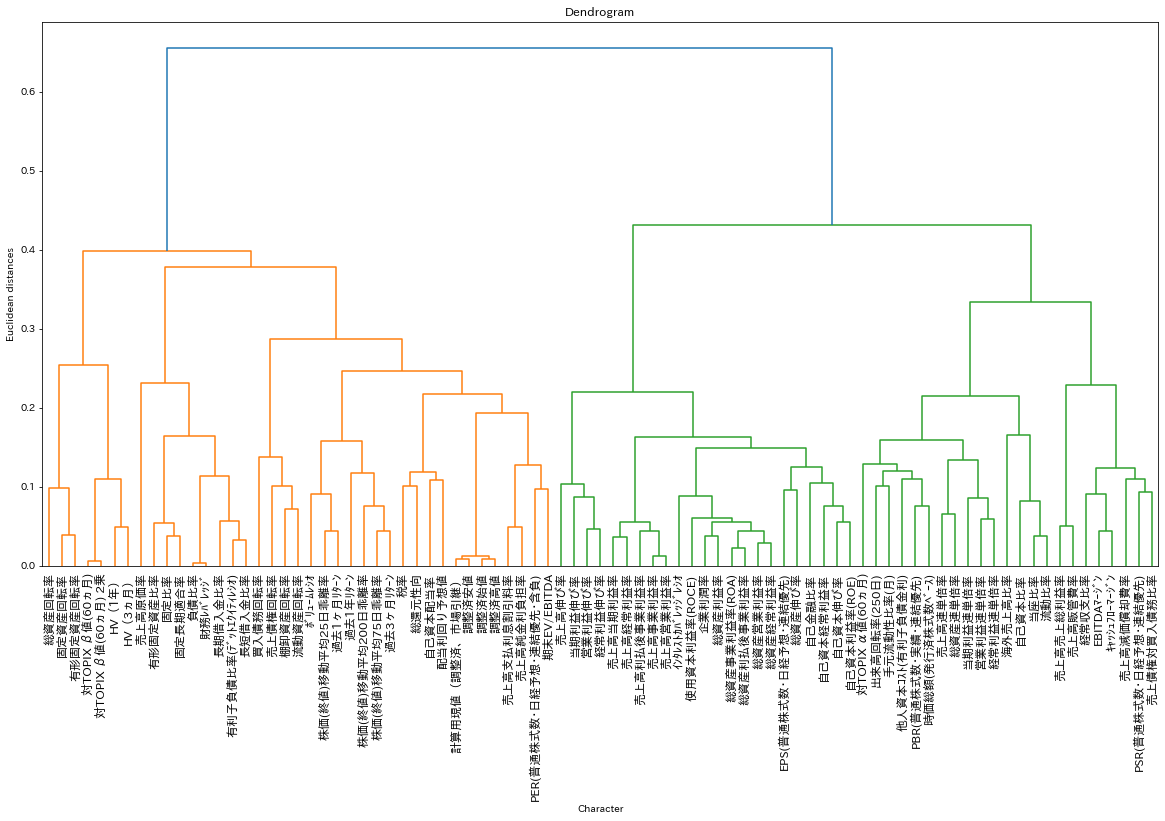

[12  5 27 27 13  2 11 33  4  4 37  6  3 16  0 16 39 11 17 36 17 19 17 22
 17 24 32 24 17 22 10 23 15 15  8  6  3 26 13  7  0 16  2  9  1  9 20  8
 20 31 38  6  3 12  4  5  4  4  4  0  4 10 18 28 28  8 28 34 35 14 14 14
 14 30 30 21  1 29  9 25  7  7  4 12  1]


In [11]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import japanize_matplotlib
import matplotlib.pyplot as plt

#X = keisu_frame_5.values.T
X = keisu_frame_5.T

#樹形図作成用インスタンス
#dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward')

# クラスタリングの実行
clu = sch.linkage(X, method='ward', metric='euclidean')

# 描画領域の定義
plt.figure(num=None, figsize=(20, 10))

# 樹形図の作成・出力
sch.dendrogram(clu, labels=list(keisu_frame_5.columns), leaf_font_size=12, leaf_rotation=90)

#樹形図可視化
plt.title('Dendrogram')
plt.xlabel('Character')
plt.ylabel('Euclidean distances')
plt.savefig("dendrogram.png")
plt.show()

hir_clus   = AgglomerativeClustering(n_clusters = 40, affinity = 'euclidean', linkage = 'ward')
y_hir_clus = hir_clus.fit_predict(X)

print(y_hir_clus)

## 6.2 階層クラスタリング結果を踏まえたデータフレームの作成

In [12]:
clustered_data_1 = pd.Series(y_hir_clus, name='cluster')
clustered_data_2 = clustered_data_1.set_axis(keisu_frame_5.T.index, axis=0)
clustered_data_3 = pd.concat([clustered_data_2, keisu_frame_5.T], axis=1)
display(clustered_data_3)

,cluster,0,1,2,3,4,5,6,7,8,...,206,207,208,209,210,211,212,213,214,215
EBITDAﾏｰｼﾞﾝ,12,-0.013205,-0.000214,0.009274,0.006789,-0.002925,-0.000098,0.009417,0.012373,-0.005636,...,0.001034,-0.020922,-0.015923,0.023069,-0.009904,-0.002242,0.001604,0.004082,0.001172,0.013795
EPS(普通株式数･日経予想･連結優先),5,0.003155,-0.000038,0.000690,-0.000215,0.000941,0.005325,-0.003687,0.011149,0.009806,...,-0.002082,-0.005952,-0.003802,0.009131,-0.011708,0.001627,-0.005013,0.005173,0.008338,-0.001994
HV（1年）,27,-0.017531,0.001335,-0.002107,0.005623,0.001646,0.003582,0.005761,0.001796,0.005204,...,-0.004506,0.000519,-0.000881,-0.011357,0.004377,-0.005456,0.000826,-0.004775,0.001295,0.001150
HV（3ヵ月）,27,-0.015262,0.000434,-0.000607,0.002829,0.000673,0.004994,0.007593,0.004031,-0.002007,...,0.002178,0.001378,-0.000505,-0.008660,0.005072,-0.007527,0.002871,-0.003777,0.003473,0.002543
PBR(普通株式数･実績･連結優先),13,-0.005893,0.002552,-0.001425,0.001598,-0.000413,-0.000498,-0.002435,0.001709,0.000674,...,0.002147,-0.010027,-0.006106,0.009055,-0.010366,-0.007476,-0.002433,-0.002381,0.003061,0.013045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
長期借入金比率,7,-0.006188,0.012238,0.001157,-0.001558,0.005603,0.004747,-0.011187,-0.007777,0.001441,...,-0.000029,-0.002045,0.001485,0.003119,0.002379,0.004881,0.004503,-0.008080,-0.000978,0.001451
長短借入金比率,7,-0.005096,0.012141,-0.001483,-0.005524,0.007376,0.004546,-0.015183,-0.009432,0.001260,...,-0.000840,0.001380,0.002581,-0.002736,0.006741,0.006939,0.005055,-0.011215,-0.005991,-0.000784
ｲﾝﾀﾚｽﾄｶﾊﾞﾚｯｼﾞﾚｼｵ,4,0.013003,-0.003740,-0.001776,-0.000792,0.003720,0.001562,-0.006431,0.010042,0.012040,...,0.001719,-0.004103,-0.003295,0.002435,-0.006177,0.002493,-0.005700,0.008480,-0.001911,-0.001497
ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ,12,-0.013199,0.000294,0.010678,0.007215,-0.006086,-0.002560,0.015411,0.012364,-0.006702,...,0.001090,-0.016166,-0.016497,0.021366,-0.010447,0.001231,0.003771,0.001835,0.001005,0.008550


# 7. 変数選択の準備

## 7.1 1つの要素のみ属するクラスタの特徴量を抽出

In [13]:
clustered_data_4 = clustered_data_3['cluster'].unique()
clustered_data_4_2 = pd.DataFrame()
for i in range(clustered_data_4.shape[0]):
    clustered_data_4_1 = clustered_data_3[clustered_data_3['cluster']==clustered_data_4[i]]
    if clustered_data_4_1.shape[0] == 1: #1つの要素しかないクラスタに属する特徴量を抽出
        clustered_data_4_2 = pd.concat([clustered_data_4_2, clustered_data_4_1])
#print(abs(clustered_data_4_2.iloc[:,1:].T).mean()/clustered_data_4_2.iloc[:,1:].T.std())
clustered_data_4_3 = clustered_data_4_2.sort_values(by=['cluster']) #cluster番号でソートする
display(clustered_data_4_3)

,cluster,0,1,2,3,4,5,6,7,8,...,206,207,208,209,210,211,212,213,214,215
総還元性向,18,-0.001086,-0.001772,0.002530,0.002233,-0.009683,-0.004639,0.004074,-0.005078,-0.010203,...,0.000943,0.001377,0.002907,-0.003766,0.002832,-0.006925,0.001433,-0.003010,-0.003813,-0.003836
売上高原価率,19,-0.006414,0.013016,-0.003954,-0.009883,0.011790,0.008935,-0.023033,-0.018108,0.014800,...,0.002711,0.021971,0.013447,-0.025592,0.021267,0.010832,0.005868,0.000804,-0.012449,-0.027860
買入債務回転率,21,0.010736,-0.005572,0.012351,0.007684,0.003808,0.006920,-0.001518,-0.013299,-0.011540,...,0.000395,-0.019144,-0.007606,0.029443,-0.012934,-0.002429,0.009186,-0.002040,0.001925,0.019709
対TOPIX α値(60ヵ月),23,-0.019735,0.006882,-0.005131,0.003147,0.004528,-0.003347,-0.004720,0.012031,0.002283,...,-0.002055,0.001705,-0.000888,-0.013046,0.000394,-0.000302,-0.007201,-0.000202,0.000270,-0.002495
配当利回り予想値,25,0.020110,0.001275,-0.000546,-0.003904,0.001599,-0.003939,-0.008329,-0.005798,0.004001,...,-0.001465,0.006441,0.003123,-0.009663,-0.000668,0.002281,-0.001220,0.003843,0.008343,-0.001127
手元流動性比率(月),26,-0.005001,-0.001689,0.001152,0.002163,-0.000363,-0.008920,0.001806,0.001246,0.000373,...,-0.002124,-0.005138,-0.008153,-0.000814,-0.006114,-0.013294,-0.002582,0.006555,-0.001763,-0.000100
過去1年ﾘﾀｰﾝ,29,-0.020638,0.006356,-0.000642,-0.004642,-0.001773,-0.007308,-0.015565,0.001316,-0.002087,...,-0.004333,-0.004376,0.003275,0.011778,0.000018,0.014453,-0.007128,-0.001614,-0.001683,-0.005192
海外売上高比率,31,0.003268,-0.002845,-0.007773,0.010130,-0.008705,-0.004411,-0.005341,0.000783,0.006851,...,0.006629,-0.004155,-0.003013,0.003607,-0.011001,-0.010582,-0.001856,-0.000859,0.007370,0.006555
売上高減価償却費率,32,-0.016950,-0.001749,0.014358,0.005112,-0.015724,-0.002426,0.023360,0.008932,-0.016936,...,-0.002235,-0.020357,-0.014571,0.031306,-0.011076,-0.003593,0.003960,-0.000601,0.002938,0.013007
他人資本ｺｽﾄ(有利子負債金利),33,-0.009970,0.005065,0.000939,0.002059,-0.006888,-0.000735,0.004186,0.001766,0.000642,...,-0.007429,-0.003127,-0.006101,0.002859,-0.005621,-0.006962,-0.004464,0.003369,0.011320,0.003489


In [14]:
clustered_data_4_3.index

Index(['総還元性向', '売上高原価率', '買入債務回転率', '対TOPIX α値(60ヵ月)', '配当利回り予想値',
       '手元流動性比率(月)', '過去1年ﾘﾀｰﾝ', '海外売上高比率', '売上高減価償却費率', '他人資本ｺｽﾄ(有利子負債金利)',
       '自己資本配当率', '自己金融比率', '売上高伸び率', '出来高回転率(250日)', '税率', '売上債権回転率'],
      dtype='object')

## 7.2 2つ以上の要素が属するクラスタの特徴量を抽出

In [15]:
clustered_data_4_5 = pd.DataFrame()
clustered_data_4_9 = pd.DataFrame()
for i in range(clustered_data_4.shape[0]):
    clustered_data_4_4  = clustered_data_3[clustered_data_3['cluster']==clustered_data_4[i]]
    if clustered_data_4_4 .shape[0] > 1: #1つの要素しかないクラスタに属する特徴量を抽出
        clustered_data_4_5  = pd.concat([clustered_data_4_5 , clustered_data_4_4 ])
        print(clustered_data_4_4['cluster'])
        #print('各特徴量のβ値の算術平均値：')
        #print(clustered_data_4_4.iloc[:,1:].T.mean())
        #print('各特徴量のβ値の絶対平均値：')
        #print(abs(clustered_data_4_4.iloc[:,1:].T).mean())
        print('各特徴量のβ値の絶対平均値を用いたシャープレシオ：')
        #print(abs(clustered_data_4_4.iloc[:,1:].T).mean()/clustered_data_4_4.iloc[:,1:].T.std())
        #print(abs(clustered_data_4_4.iloc[:,1:].T).mean()/abs(clustered_data_4_4.iloc[:,1:].T).std())
        print(abs(clustered_data_4_4.iloc[:,1:].T).mean()/(clustered_data_4_4.iloc[:,1:].T).std())
        clustered_data_4_7 = abs(clustered_data_4_4.iloc[:,1:].T).mean()/clustered_data_4_4.iloc[:,1:].T.std()
        #print('各クラスタにおけるシャープレシオ最大の特徴量：')
        #print(pd.DataFrame(clustered_data_4_7).idxmax())
        clustered_data_4_8 = pd.DataFrame(clustered_data_4_7).idxmax()
        
        #clustered_data_4_8 = pd.concat([pd.DataFrame(clustered_data_4_7) , clustered_data_4_4.iloc[:,0] ], axis=1)
        
        clustered_data_4_9 = pd.concat([clustered_data_4_9 , clustered_data_4_8 ]) #抽出対象となる特徴量
        #print(clustered_data_4_4.index)
clustered_data_4_6 = clustered_data_4_5.sort_values(by=['cluster']) #cluster番号でソートする
display(clustered_data_4_6)

EBITDAﾏｰｼﾞﾝ      12
経常収支比率           12
ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ    12
Name: cluster, dtype: int64
各特徴量のβ値の絶対平均値を用いたシャープレシオ：
EBITDAﾏｰｼﾞﾝ      0.773324
経常収支比率           0.781141
ｷｬｯｼｭﾌﾛｰﾏｰｼﾞﾝ    0.781845
dtype: float64
EPS(普通株式数･日経予想･連結優先)    5
総資産伸び率                  5
Name: cluster, dtype: int64
各特徴量のβ値の絶対平均値を用いたシャープレシオ：
EPS(普通株式数･日経予想･連結優先)    0.787958
総資産伸び率                  0.750240
dtype: float64
HV（1年）     27
HV（3ヵ月）    27
Name: cluster, dtype: int64
各特徴量のβ値の絶対平均値を用いたシャープレシオ：
HV（1年）     0.769468
HV（3ヵ月）    0.762166
dtype: float64
PBR(普通株式数･実績･連結優先)    13
時価総額(発行済株式数ﾍﾞｰｽ)      13
Name: cluster, dtype: int64
各特徴量のβ値の絶対平均値を用いたシャープレシオ：
PBR(普通株式数･実績･連結優先)    0.754221
時価総額(発行済株式数ﾍﾞｰｽ)      0.796687
dtype: float64
PER(普通株式数･日経予想･連結優先･含負)    2
期末EV/EBITDA                2
Name: cluster, dtype: int64
各特徴量のβ値の絶対平均値を用いたシャープレシオ：
PER(普通株式数･日経予想･連結優先･含負)    0.797965
期末EV/EBITDA                0.772188
dtype: float64
PSR(普通株式数･日経予想･連結優先)    11
売上債権対買入債務比率             11
Name: cluster, dtype: int64
各特徴量のβ値

,cluster,0,1,2,3,4,5,6,7,8,...,206,207,208,209,210,211,212,213,214,215
固定資産回転率,0,0.014921,0.004183,-0.016354,-0.006498,0.005431,-0.001654,-0.003390,0.008374,0.016157,...,-0.000835,0.016301,0.013867,-0.025690,0.002533,0.000116,-0.005693,-0.001325,0.004499,-0.009156
総資産回転率,0,0.020678,0.001626,-0.006491,0.001202,0.001966,0.005601,0.000873,0.000071,0.006747,...,-0.000747,0.007829,0.011723,-0.014455,0.000559,0.002203,-0.002368,-0.000267,0.005196,-0.001996
有形固定資産回転率,0,0.010385,0.002366,-0.015149,-0.006481,0.008006,-0.001099,-0.003323,0.006138,0.015138,...,-0.000643,0.016786,0.014146,-0.027129,0.004730,-0.005187,-0.005797,-0.000229,0.006023,-0.010416
株価(終値)移動平均25日乖離率,1,-0.007741,0.008389,0.001334,0.000985,-0.000238,-0.005899,0.000436,0.017654,-0.008559,...,0.004430,-0.005273,-0.000218,0.008521,0.013020,0.006363,0.000513,-0.005500,-0.005088,0.001911
過去1ヶ月ﾘﾀｰﾝ,1,-0.010138,0.009378,0.001721,-0.001225,0.003702,-0.007976,-0.004407,0.014433,-0.007580,...,0.005321,-0.002567,0.001401,0.009322,0.009998,0.010224,-0.000535,-0.005087,-0.007360,0.002578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
自己資本伸び率,28,0.006279,0.000543,-0.003503,0.002220,0.010893,0.002815,-0.002059,0.006545,0.006072,...,0.003488,-0.004017,-0.002985,-0.001837,-0.004552,0.011935,-0.002673,0.000749,-0.004439,-0.002889
自己資本経常利益率,28,0.013779,0.001550,-0.008345,-0.002953,0.007573,0.002923,-0.012601,0.005674,0.012887,...,0.001411,-0.002663,-0.003301,-0.001703,-0.004616,0.006991,-0.001050,0.001564,-0.001001,0.002775
自己資本利益率(ROE),28,0.011034,0.000757,-0.006052,0.001280,0.009994,0.000718,-0.006684,0.006503,0.009240,...,0.001366,-0.003435,-0.006398,-0.000923,-0.006360,0.005443,-0.001832,0.004553,0.002254,0.001547
負債比率,30,-0.008203,0.010809,-0.008149,-0.010741,0.012831,0.007059,-0.016725,-0.010912,0.006012,...,0.001835,0.013325,0.011956,-0.012819,0.013891,0.011968,0.004833,-0.011189,-0.008297,-0.009804


# 8. 変数選択
シャープレシオが最大の特徴量をそれぞれ選択

In [16]:
chosed_data_1 = pd.concat([pd.DataFrame(clustered_data_4_3.index) , clustered_data_4_9 ]).reset_index().iloc[:,1]
chosed_data_2 = chosed_data_1.sort_values().reset_index().iloc[:,1] #名前順に並び替え
display(chosed_data_2)

0        EPS(普通株式数･日経予想･連結優先)
1                      HV（1年）
2     PER(普通株式数･日経予想･連結優先･含負)
3            他人資本ｺｽﾄ(有利子負債金利)
4                出来高回転率(250日)
5                     売上債権回転率
6                 売上債権対買入債務比率
7                      売上高伸び率
8                      売上高原価率
9                   売上高売上総利益率
10                売上高支払利息割引料率
11                  売上高減価償却費率
12                   売上高経常利益率
13                    売上高連単倍率
14            対TOPIX α値(60ヵ月)
15            対TOPIX β値(60ヵ月)
16                       当座比率
17                    当期利益伸び率
18                   当期利益連単倍率
19                 手元流動性比率(月)
20           時価総額(発行済株式数ﾍﾞｰｽ)
21                  有形固定資産回転率
22                   有形固定資産比率
23           株価(終値)移動平均75日乖離率
24                    流動資産回転率
25                    海外売上高比率
26                         税率
27                     総資産利益率
28                      総還元性向
29               自己資本利益率(ROE)
30                    自己資本配当率
31                     自己金融比率
32                      調整済高値
33        

In [17]:
with pd.ExcelWriter('/Users/nagashimahikaru/Documents/修士論文/使用データ/chosen character.xlsx') as writer: 
    chosed_data_2.to_excel(writer)

#先生に指標を確認してもらうためのファイルの書き出し
a = abs(clustered_data_4_2.iloc[:,1:].T).mean()/(clustered_data_4_2.iloc[:,1:].T).std()
b = pd.concat([clustered_data_4_9, a])
c = b.sort_values(by=['cluster'])
c = c.rename(columns={0: 'シャープレシオ'})
with pd.ExcelWriter('/Users/nagashimahikaru/Documents/修士論文/使用データ/file for check2.xlsx') as writer: 
    c.to_excel(writer)
d = kaiki_data_4['期日'].unique()
e = pd.concat([pd.DataFrame(d),keisu_frame_5], axis=1)
e = e.rename(columns={0: '日付'})
f = e.set_index('日付')
with pd.ExcelWriter('/Users/nagashimahikaru/Documents/修士論文/使用データ/file for check3.xlsx') as writer: 
    f.T.to_excel(writer)